In [7]:
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


In [8]:
# Parameters
image_size = (256, 256)  # Resize all images to this size
batch_size = 32
seed = 123

image_directory = r"C:\Users\pasir\Desktop\PR_assignment\realwaste\realwaste-main\RealWaste"

# Load the dataset
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)


Found 4752 files belonging to 9 classes.


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


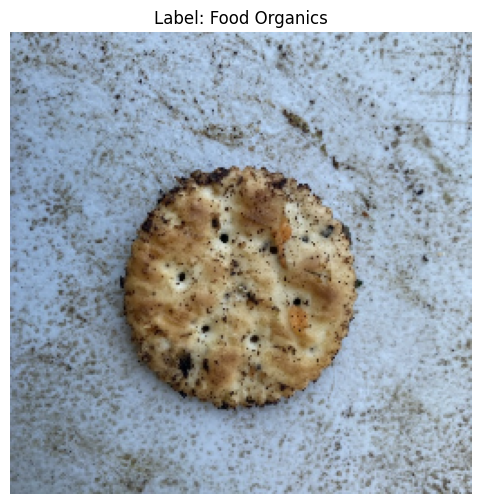

In [9]:
# Display class names
class_names = full_dataset.class_names
print("Classes:", class_names)

# Inspect a batch of images and labels
for images, labels in full_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    image = images[0].numpy().astype("uint8")  
    label = labels[0].numpy()
# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image)  
plt.title(f"Label: {class_names[label]}")  
plt.axis("off")  
plt.show()

In [10]:
# Get the total number of samples
num_samples = len(full_dataset.file_paths)


# Calculate the split sizes
train_size = int(0.6 * num_samples/32)
val_size = int(0.2 * num_samples/32)
test_size = int(num_samples/32 - train_size - val_size)  # Ensure all data is used



# Split the dataset
train_dataset = full_dataset.take(train_size)
remainder_dataset = full_dataset.skip(train_size)

val_dataset = remainder_dataset.take(val_size)
test_dataset = remainder_dataset.skip(val_size)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize data loading
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Total samples: {num_samples}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Total samples: 4752
Training samples: 89
Validation samples: 29
Test samples: 30


In [11]:

# Define the CNN model
model = keras.Sequential([
    # First Convolutional Layer with 32 filters and a 3x3 kernel
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),

    # MaxPooling layer to downsample the feature maps
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Layer with 64 filters and a 3x3 kernel
    layers.Conv2D(64, (3, 3), activation='relu'),

    # MaxPooling layer to downsample the feature maps
    layers.MaxPooling2D((2, 2)),

    # Flatten the 2D feature maps to a 1D array
    layers.Flatten(),

    # Add a dense (fully connected) layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu'),

    # Add another dense layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu'),

    # Add the output layer with 10 units (one for each class) and softmax activation
    layers.Dense(9, activation='softmax')
])
model.summary()

learning_rate = 0.001

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [12]:
# Train the model and collect training history
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10
89/89 [==============================] - 7s 75ms/step - loss: 2.4223 - accuracy: 0.2802 - val_loss: 1.7291 - val_accuracy: 0.3675
Epoch 2/10
89/89 [==============================] - 7s 75ms/step - loss: 1.4338 - accuracy: 0.4870 - val_loss: 1.5811 - val_accuracy: 0.4321
Epoch 3/10
89/89 [==============================] - 7s 76ms/step - loss: 1.1552 - accuracy: 0.6057 - val_loss: 1.3394 - val_accuracy: 0.5302
Epoch 4/10
89/89 [==============================] - 7s 81ms/step - loss: 0.7418 - accuracy: 0.7521 - val_loss: 1.3628 - val_accuracy: 0.5797
Epoch 5/10
89/89 [==============================] - 9s 97ms/step - loss: 0.4201 - accuracy: 0.8754 - val_loss: 1.4714 - val_accuracy: 0.5862
Epoch 6/10
89/89 [==============================] - 10s 106ms/step - loss: 0.2103 - accuracy: 0.9407 - val_loss: 1.5563 - val_accuracy: 0.5894
Epoch 7/10
89/89 [==============================] - 10s 105ms/step - loss: 0.1339 - accuracy: 0.9705 - val_loss: 1.6795 - val_accuracy: 0.6196
Epoch 8/1

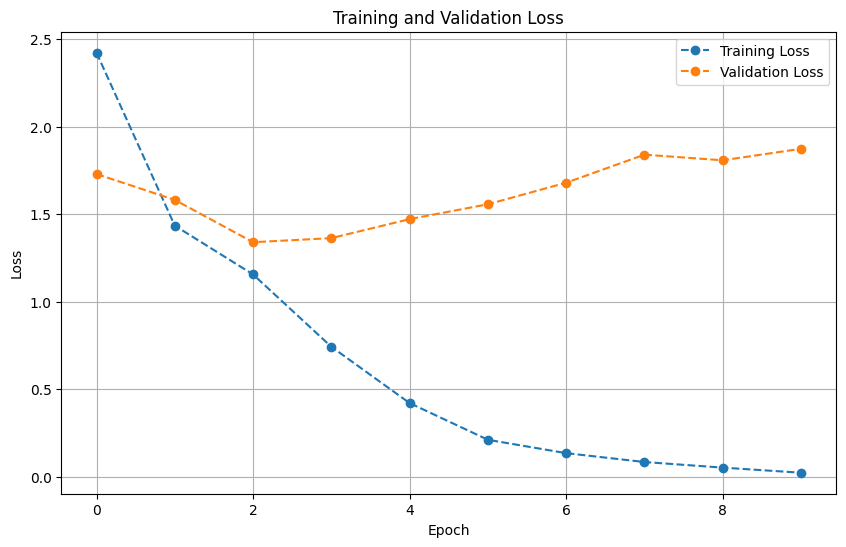

In [13]:
# Plot training, validation, and testing loss with respect to epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Evaluate the model on the test data and collect test loss
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

31/31 [==============================] - 3s 27ms/step - loss: 2.7115 - accuracy: 0.5318
Test Loss: 2.7114813327789307
Test Accuracy: 0.5317623019218445
